<a href="https://colab.research.google.com/github/Jojo18-20/AI_course_submission/blob/main/modul5_assigment3_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Johanna Schaefer -Module 5- Assigment 3

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics.pairwise as dis_lib


In [2]:
data_df = pd.read_csv("dataset_exercise_5_clustering_highway_traffic.csv",sep=";")

In [3]:
# Sort the DataFrame 'data_df' by columns "Date" and "Interval_5"
data_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted DataFrame
days = np.unique(data_df[['Date']].values.ravel())
# Calculate the total number of unique days
ndays = len(days)

# Group the DataFrame 'data_df' by the "Date" column
day_subsets_df = data_df.groupby(["Date"])

# Define the total number of 5-minute intervals in a day
nintvals = 288

# Create a matrix 'vectorized_day_dataset' filled with NaN values
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)

# Loop through each unique day
for i in range(0, ndays):
    # Get the DataFrame corresponding to the current day
    df_t = day_subsets_df.get_group(days[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame
        df_t = day_subsets_df.get_group(days[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset'
        vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset'
print(vectorized_day_dataset)

/tmp/ipython-input-2050002240.py:22: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(days[i])
/tmp/ipython-input-2050002240.py:27: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(days[i])


[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]


Data exploration

In [4]:
print('number of nans',np.sum(np.isnan(vectorized_day_dataset)))
print('rate of nans',np.sum(np.isnan(vectorized_day_dataset))/(ndays*nintvals))

number of nans 277
rate of nans 0.0026350837138508373


(288,)


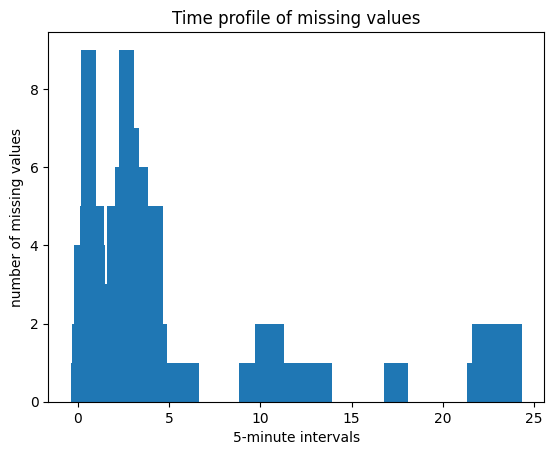

In [5]:
nans_per_time = np.sum(np.isnan(vectorized_day_dataset),0)
print(nans_per_time.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Create an array 'x_axis' representing the 5-minute intervals
x_axis = np.arange(0, nintvals, 1, dtype=int)
# Initialize an empty list 'x_axis_hours' to store time values in hours
x_axis_hours = []
# Convert interval indices to hours and append them to 'x_axis_hours'
for i in range(0, len(x_axis)):
  x_axis_hours.append(float(x_axis[i]*5)/60)
ax.bar(x_axis_hours,height=nans_per_time)


ax.set_ylabel('number of missing values')
ax.set_xlabel('5-minute intervals')
ax.set_title('Time profile of missing values')

plt.show()

In [6]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))

number of days with missing value 28


In [7]:
print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

[ 25  49  52  86  87  88 137 138 139 185 187 207 208 209 217 247 248 249
 250 251 266 275 276 277 299 306 311 341]


Split dataset in test and train

In [29]:
#X_train, X_test = train_test_split(vectorized_day_dataset_no_nans, test_size=0.2, random_state=42, shuffle=True)
X_train, X_test, days_train_not_nans, days_test_not_nans = train_test_split(
    vectorized_day_dataset_no_nans,
    days_not_nans,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

269


array([[56., 36., 46., ..., 79., 67., 62.],
       [13., 17., 17., ..., 31., 16., 15.],
       [56., 54., 62., ..., 18., 17., 11.],
       ...,
       [49., 22., 32., ..., 70., 75., 67.],
       [26., 12., 25., ..., 47., 40., 38.],
       [30., 50., 39., ..., 26., 22., 31.]])

Find eps for DB-clustering

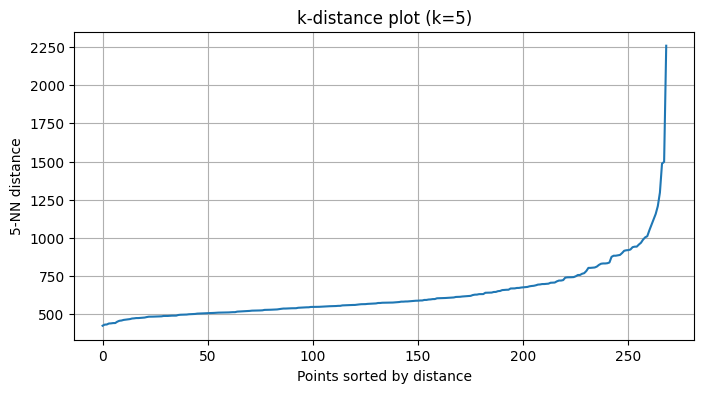

eps candidates (use one near knee): [648.54544724 706.48908582 762.88435836 845.68936303 950.47868673]


In [37]:
min_samples = 6
k = min_samples - 1  # k-th neighbor
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_train)
distances, indices = nbrs.kneighbors(X_train)
k_dist = np.sort(distances[:, k])

# Plot
plt.figure(figsize=(8,4))
plt.plot(k_dist)
plt.ylabel(f"{k}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title(f"k-distance plot (k={k})")
plt.grid()
plt.show()

# eps-candidates:
eps_candidates = np.percentile(k_dist, [70, 80, 85, 90, 95])
print("eps candidates (use one near knee):", eps_candidates)


Visualisation

In [25]:
from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors
import datetime


def assign_colors(n_clusters, days, assigments):

    days_colors = []
    color_to_cluster = []
    style_to_cluster = []
    weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']#,'#fe9929','#cc4c02','#e31a1c','#737373','#bdbdbd','#252525','#bcbddc']
#    weekend_school_colors = ['#c2a5cf','#f1b6da','#8e0152','#c51b7d','#de77ae','#ae017e','#fcc5c0','#e31a1c','#737373','#bdbdbd']
#    bank_holidays_colors = ['#543005','#dfc27d','#bf812d','#8c510a']
    mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
    weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

    cluster_id_weekdays_share = []
    cluster_id_weekend_share = []
    cluster_id_all_days = []

    for i in range(0,n_clusters):
        color_to_cluster.append(None)
        style_to_cluster.append(None)
        cluster_id_weekdays_share.append(0)
        cluster_id_weekend_share.append(0)
        cluster_id_all_days.append(0)

    for i in range(0,len(days)):
        #print(i,assigments[i],len(assigments),len(cluster_id_all_days))
        if assigments[i] is not None:
            cluster_id_all_days[assigments[i]] += 1
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

            if int(pomT.weekday()) < 5:
                cluster_id_weekdays_share[assigments[i]] += 1
            else:
                cluster_id_weekend_share[assigments[i]] += 1

    print('cluster_id_weekdays_share',cluster_id_weekdays_share)
    print('cluster_id_weekend_share',cluster_id_weekend_share)
    for i in range(0,len(days)):
        if assigments[i] is not None:
            cluster_idx = assigments[i]
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
            if color_to_cluster[assigments[i]] is None:
                if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekend_colors.pop()
                        style_to_cluster[assigments[i]] = ':'
                elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekday_colors.pop(0)
                        style_to_cluster[assigments[i]] = '-'
                else:
                    color_to_cluster[assigments[i]] = mixed_colors.pop()
                    style_to_cluster[assigments[i]] = ':'

            days_colors.append(color_to_cluster[assigments[i]])
        else:
            days_colors.append(None)

    return days_colors,color_to_cluster,style_to_cluster


def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster,
           limit_graphics=False):

    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders

    xticks, labels = [], []
    start = datetime.datetime(year,1,1).weekday()

    for month in range(1,13):

        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]

        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",

                       linewidth=1, zorder=20, clip_on=False)

        ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(0.5 + np.arange(7))
        ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
        ax.set_title("{}".format(year), weight="semibold")
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)

    # Clearing first and last day from the data
    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
        if '-' in str(days[i]):
            pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
            pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
        week_number = int(pomT.strftime("%W"))
        day_of_week = int(pomT.weekday())
        data[day_of_week,week_number] = assigments[i]


    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):

        week_number = int(act_date.strftime("%W"))
        day_of_week = int(act_date.weekday())
        doy_id = act_date.timetuple().tm_yday
        if doy_id<5 and week_number > 53:
            week_number = 0

        act_date = act_date + datetime.timedelta(days=1)

    #pomT = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
    #week_number = int(pomT.strftime("%V"))
    #day_of_week = int(pomT.weekday())
    #print(week_number,day_of_week)
    #doy_id = pomT.timetuple().tm_yday
    #if doy_id<5 and week_number > 0:
    #    week_number = 0
    #data[day_of_week,week_number] = len(clusters)+10

    # Showing data
    cmap = plt.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')

    #ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=0, vmax=len(clusters)+10,
    #          cmap=cmap, origin="lower", alpha=.75)

    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
        bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    #print(color_to_cluster)
   #print(bounds)
    #print(norm)

    #print(color_to_cluster)
    #print(bounds)
    #print(cmap)
    #exit(0)

    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster,
                                       save_figure: str = None, show_figure:bool = True, limit_graphics = False):

    fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
    X = np.linspace(-1,1, 53*7)

    for i, obj in enumerate(years):

        pom_s = str(len(years))+'1'+str(i+1)
        print(pom_s)

        ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
        I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
        I = I.reshape(53,7).T
        I.fill(np.nan)
        calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

    #   ax = plt.subplot(212, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #  I = 1.1 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #   calmap(ax, 2018, I.reshape(53,7).T)

    #ax = plt.subplot(313, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #I = 1.0 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #calmap(ax, 2019, I.reshape(53,7).T)
    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()


def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None,
                          save_figure: str = None, show_figure:bool = True):

    #print(color_to_cluster)
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    for i in range(0,len(x)):
        #print(i,color_to_cluster[i],style_to_cluster[i])
        #print(y[i])
        ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Flow')
    if minY is not None and maxY is not None:
        ax.set_ylim([minY, maxY])
    plt.legend()

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()



# **Clustering**

Closest centroid

In [ ]:
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    for i in range(len(centroids)):
        # nur den relevanten Zeitbereich vergleichen
        ed_t = dis_lib.paired_distances(
            centroids[i][:, from_interval+1:to_interval+1],
            new_day[:, from_interval+1:to_interval+1],
            metric='euclidean'
        )[0]

        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid

Function for Clustering +internal +external evaluation

---



In [35]:
def evaluate_clustering(method, model, X_train, X_test, params):
    labels = None
    if method == "GMM":
      labels=model.fit(X_train).predict(X_train)
        #model.fit(X_train)
        #labels = model.predict(X_train)
    else:
        clusters = model.fit(X_train)
        if clusters is not None:
          labels = clusters.labels_
        #labels = model.fit_predict(X_train)

    #internal evaluation
    if len(np.unique(labels)) > 1 and np.any(labels != -1):
        sil = silhouette_score(X_train, labels)
        db  = davies_bouldin_score(X_train, labels)
        ch  = calinski_harabasz_score(X_train, labels)
    else:
        sil, db, ch = np.nan, np.nan, np.nan




    # Calculate the number of clusters by finding unique values in 'cluster_labels'
    n_clusters_t = len(np.unique(labels))

    # Assign colors to days based on clusters
    days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_train_not_nans, labels)
    # The function 'assign_colors' is used to determine colors and styles for visualization.

    # Create a calendar visualization figure
    make_calendar_visualization_figure(days_train_not_nans, labels, n_clusters_t, [2021], days_colors,
                                      color_to_cluster, save_figure=None)
    # This function 'make_calendar_visualization_figure' is used to generate a visualization based on the provided data and parameters.
    # 'days_not_nans' are the days, 'cluster_labels' are the cluster labels, 'n_clusters_t' is the number of clusters,
    # '[2021]' represents the year, 'days_colors' represent the assigned colors for each day, 'color_to_cluster' maps colors to clusters,
    # and 'save_figure' is an optional parameter to save the generated figure (can be None if not saving).






    # Initialize a list to store centroid data
    centroids = []
    # Calculate centroids for each cluster
    for i in np.unique(labels):
      centroid = np.nanmean(X_train[np.where(labels == i)[0], :], 0).reshape(1, nintvals)
      centroids.append(centroid)

    # Define the number of past intervals to consider for classification
    n_past_intervals_for_classification = 5

    # Initialize variables to calculate accuracy metrics
    total_mae = 0
    total_mape = 0
    prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
    for i in range(0, X_test.shape[0]):
        # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
        for j in range(n_past_intervals_for_classification, nintvals - 1):
            # Find the closest centroid for the current data point
            centroid_index = find_the_closest_centroid(centroids, X_test[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

            # Predict the value for the next interval
            predicted_value = centroids[centroid_index][0, j + 1]

            # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
            mae_t = abs(predicted_value - X_test[i][j + 1])
            mape_t = abs(predicted_value - X_test[i][j + 1]) / float(X_test[i][j + 1])

            # Accumulate MAE, MAPE, and count of predictions
            total_mae += mae_t
            total_mape += mape_t
            prediction_counts += 1


    results.append({
        "Method": method,
        "Params": params,
        "Silhouette": sil,
        "DaviesBouldin": db,
        "CalinskiHarabasz": ch,
        "accuracy MAE": total_mae / prediction_counts,
        "accuracy MAPE": total_mape / prediction_counts
    })


Results for different parameters

KMeans with number of cluster: 2
cluster_id_weekdays_share [164, 28]
cluster_id_weekend_share [0, 77]
111


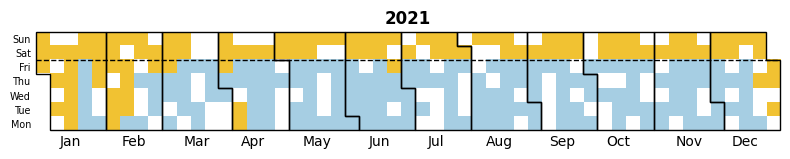

GMM with number of cluster: 2
cluster_id_weekdays_share [164, 28]
cluster_id_weekend_share [0, 77]
111


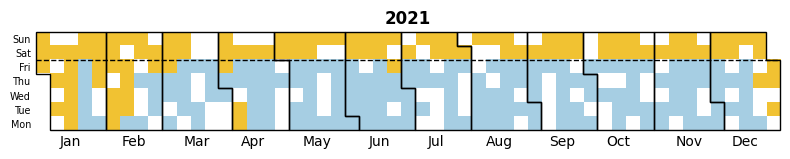

Agglomerative with number of cluster: 2
cluster_id_weekdays_share [69, 123]
cluster_id_weekend_share [77, 0]
111


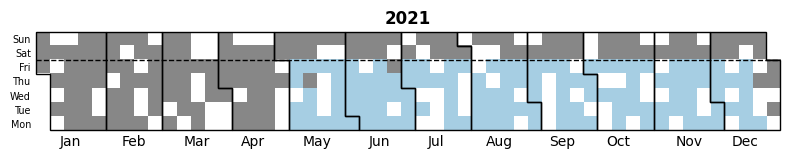

2 done
KMeans with number of cluster: 4
cluster_id_weekdays_share [89, 4, 92, 7]
cluster_id_weekend_share [0, 31, 0, 46]
111


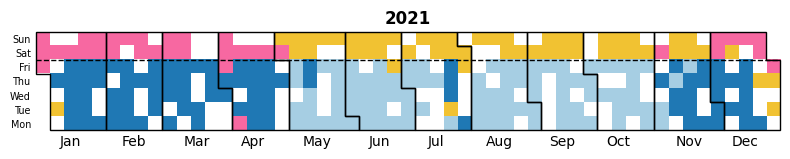

GMM with number of cluster: 4
cluster_id_weekdays_share [89, 4, 92, 7]
cluster_id_weekend_share [0, 31, 0, 46]
111


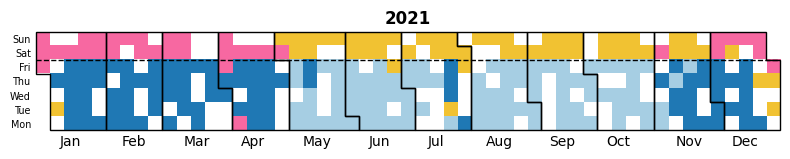

Agglomerative with number of cluster: 4
cluster_id_weekdays_share [123, 58, 4, 7]
cluster_id_weekend_share [0, 0, 37, 40]
111


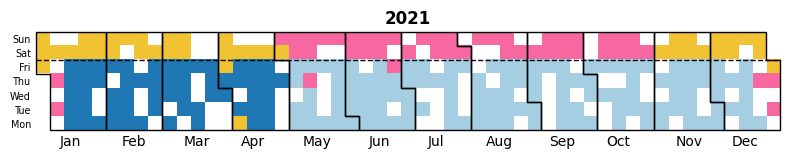

4 done
KMeans with number of cluster: 6
cluster_id_weekdays_share [29, 4, 81, 3, 54, 21]
cluster_id_weekend_share [0, 30, 0, 41, 0, 6]
111


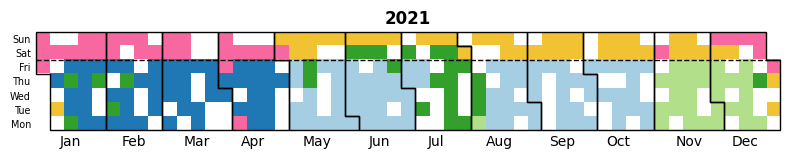

GMM with number of cluster: 6
cluster_id_weekdays_share [29, 4, 81, 3, 54, 21]
cluster_id_weekend_share [0, 30, 0, 41, 0, 6]
111


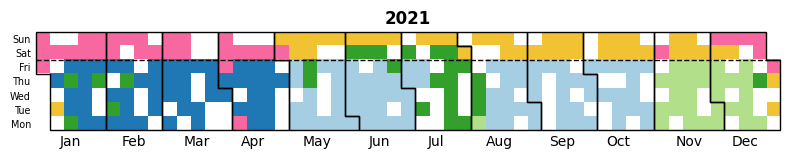

Agglomerative with number of cluster: 6
cluster_id_weekdays_share [4, 58, 42, 7, 80, 1]
cluster_id_weekend_share [37, 0, 0, 40, 0, 0]
111


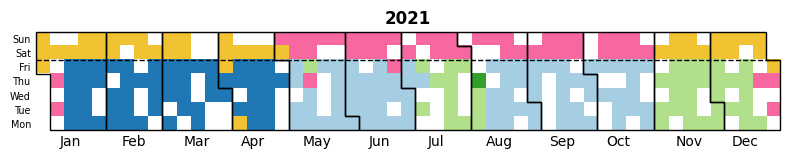

6 done
KMeans with number of cluster: 8
cluster_id_weekdays_share [20, 4, 70, 3, 50, 23, 12, 10]
cluster_id_weekend_share [0, 31, 0, 39, 0, 0, 7, 0]
111


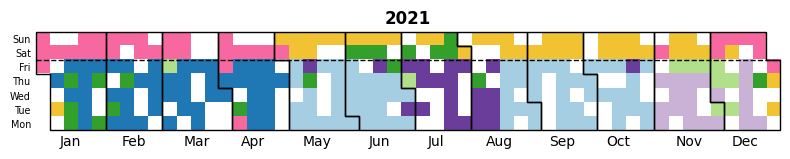

GMM with number of cluster: 8
cluster_id_weekdays_share [20, 4, 70, 3, 50, 23, 12, 10]
cluster_id_weekend_share [0, 31, 0, 39, 0, 0, 7, 0]
111


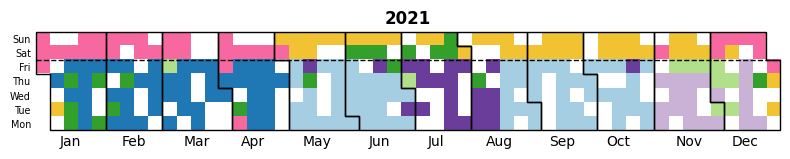

Agglomerative with number of cluster: 8
cluster_id_weekdays_share [58, 80, 3, 7, 28, 1, 1, 14]
cluster_id_weekend_share [0, 0, 17, 40, 0, 0, 20, 0]
111


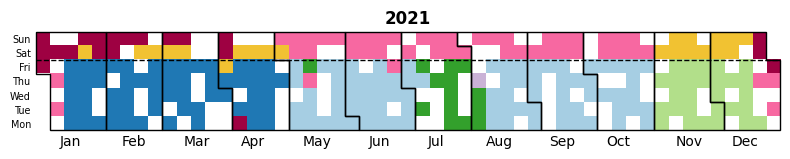

8 done
KMeans with number of cluster: 10
cluster_id_weekdays_share [3, 4, 68, 3, 32, 23, 6, 6, 25, 22]
cluster_id_weekend_share [0, 31, 0, 40, 0, 0, 6, 0, 0, 0]
111


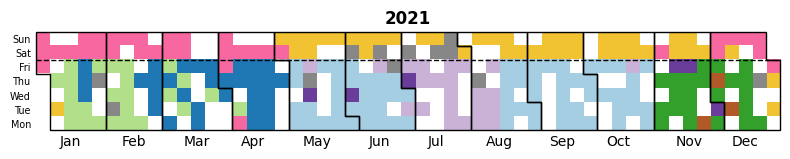

GMM with number of cluster: 10
cluster_id_weekdays_share [3, 4, 68, 3, 32, 23, 6, 6, 25, 22]
cluster_id_weekend_share [0, 31, 0, 40, 0, 0, 6, 0, 0, 0]
111


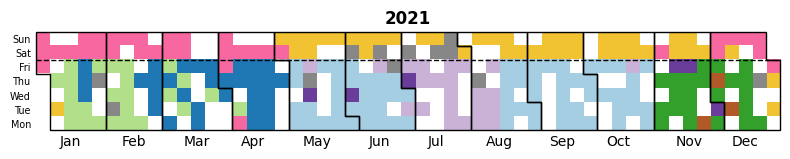

Agglomerative with number of cluster: 10
cluster_id_weekdays_share [53, 7, 3, 14, 28, 1, 1, 27, 31, 27]
cluster_id_weekend_share [0, 40, 17, 0, 0, 0, 20, 0, 0, 0]
111


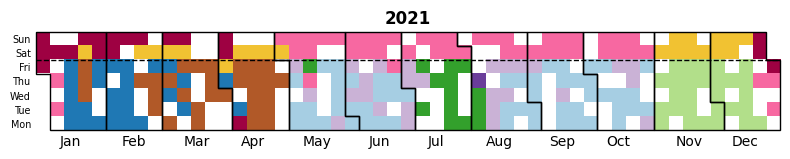

10 done
KMeans with number of cluster: 12
cluster_id_weekdays_share [3, 4, 68, 5, 34, 22, 2, 6, 24, 22, 1, 1]
cluster_id_weekend_share [0, 30, 0, 14, 0, 0, 8, 0, 0, 0, 0, 25]
111


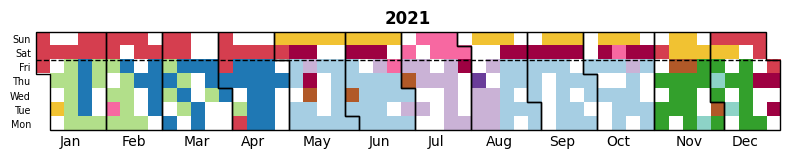

GMM with number of cluster: 12
cluster_id_weekdays_share [3, 4, 68, 5, 34, 22, 2, 6, 24, 22, 1, 1]
cluster_id_weekend_share [0, 30, 0, 14, 0, 0, 8, 0, 0, 0, 0, 25]
111


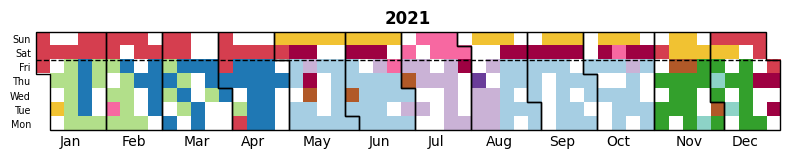

Agglomerative with number of cluster: 12
cluster_id_weekdays_share [28, 5, 3, 14, 27, 2, 1, 27, 31, 51, 2, 1]
cluster_id_weekend_share [0, 19, 17, 0, 0, 21, 20, 0, 0, 0, 0, 0]
111


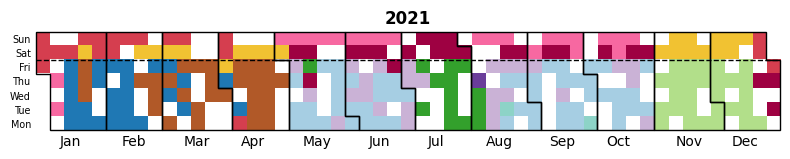

12 done
DB scan  with eps, ms: 400 4
cluster_id_weekdays_share [0, 0, 4, 188]
cluster_id_weekend_share [6, 4, 0, 67]
111


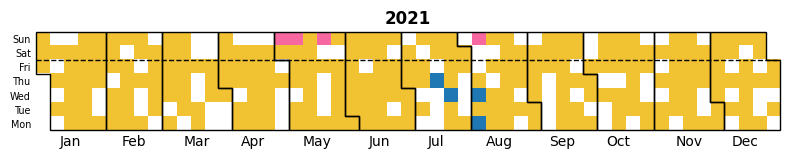

DB scan  with eps, ms: 400 5
cluster_id_weekdays_share [192]
cluster_id_weekend_share [77]
111


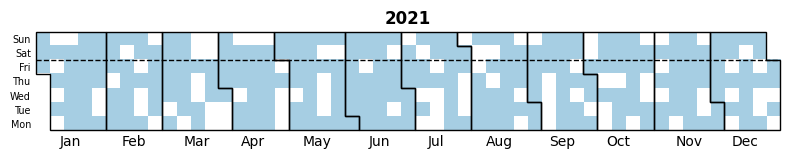

DB scan  with eps, ms: 400 6
cluster_id_weekdays_share [192]
cluster_id_weekend_share [77]
111


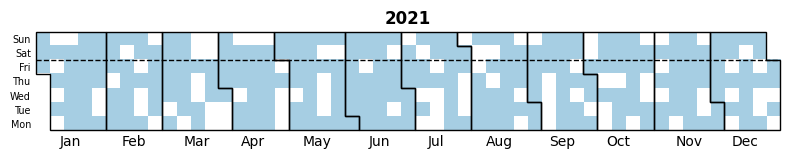

400 done
DB scan  with eps, ms: 500 4
cluster_id_weekdays_share [0, 1, 9, 25, 1, 11, 4, 7, 134]
cluster_id_weekend_share [8, 29, 0, 0, 25, 0, 0, 0, 15]
111


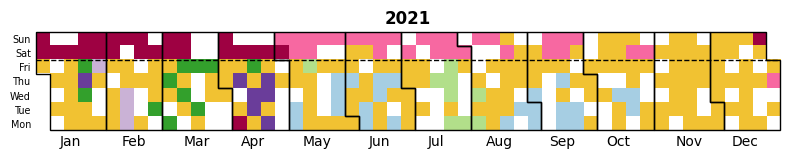

DB scan  with eps, ms: 500 5
cluster_id_weekdays_share [9, 0, 25, 1, 11, 1, 6, 139]
cluster_id_weekend_share [0, 5, 0, 25, 0, 25, 0, 22]
111


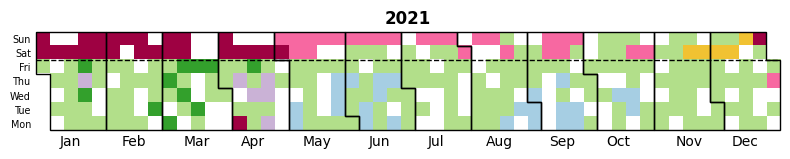

DB scan  with eps, ms: 500 6
cluster_id_weekdays_share [1, 10, 25, 1, 9, 6, 140]
cluster_id_weekend_share [25, 0, 0, 23, 0, 0, 29]
111


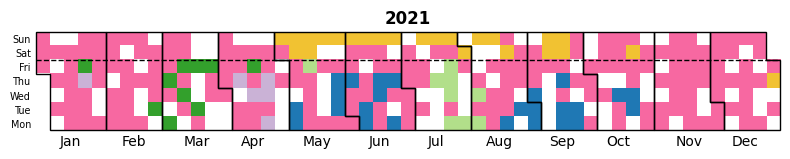

500 done
DB scan  with eps, ms: 600 4
cluster_id_weekdays_share [107, 12, 73]
cluster_id_weekend_share [69, 0, 8]
111


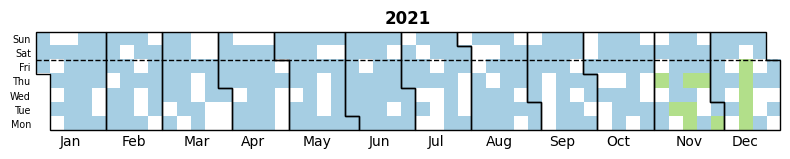

DB scan  with eps, ms: 600 5
cluster_id_weekdays_share [106, 12, 74]
cluster_id_weekend_share [69, 0, 8]
111


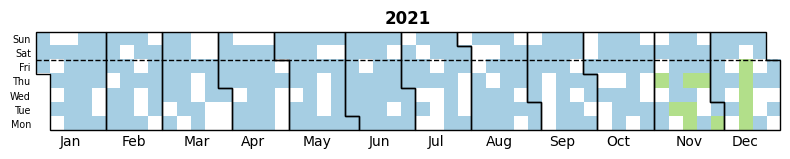

DB scan  with eps, ms: 600 6
cluster_id_weekdays_share [106, 12, 74]
cluster_id_weekend_share [69, 0, 8]
111


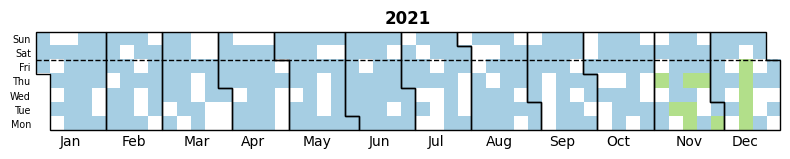

600 done
DB scan  with eps, ms: 700 4
cluster_id_weekdays_share [158, 34]
cluster_id_weekend_share [74, 3]
111


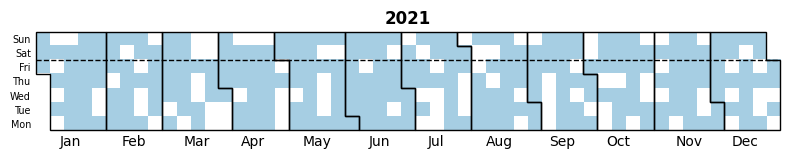

DB scan  with eps, ms: 700 5
cluster_id_weekdays_share [157, 35]
cluster_id_weekend_share [74, 3]
111


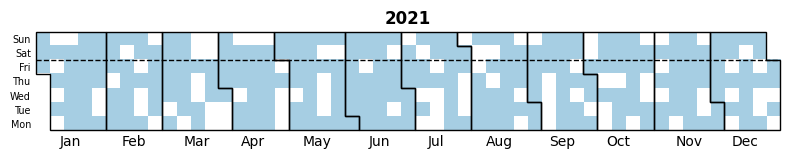

DB scan  with eps, ms: 700 6
cluster_id_weekdays_share [157, 35]
cluster_id_weekend_share [74, 3]
111


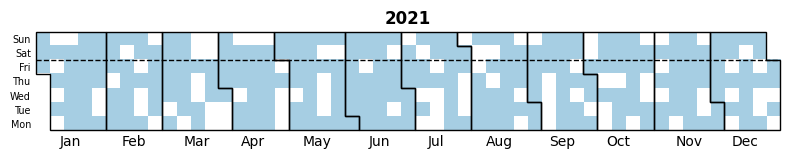

700 done


In [46]:
results = []

labels = None
n_clusters = [2,4,6,8,10,12]

for k in n_clusters:
    # KMeans
    print("KMeans with number of cluster:",k)
    km = KMeans(n_clusters=k, random_state=42)
    evaluate_clustering("KMeans", km, X_train, X_test, {"n_clusters": k})

    # GMM
    print("GMM with number of cluster:",k)
    gmm = GaussianMixture(n_components=k, random_state=42)
    evaluate_clustering("GMM", gmm, X_train, X_test, {"n_components": k})

    # Agglomerative
    print("Agglomerative with number of cluster:",k)
    agg = AgglomerativeClustering(n_clusters=k)
    evaluate_clustering("Agglomerative", agg, X_train, X_test, {"n_clusters": k})

    print(k,"done")

# DBSCAN separate, eps und min_samples vary
for eps in [400, 500, 600, 700]:
    for ms in [4,5,6]:
        print("DB scan  with eps, ms:",eps,ms)
        db = DBSCAN(eps=eps, min_samples=ms)
        evaluate_clustering("DBSCAN", db, X_train, X_test, {"eps": eps, "min_samples": ms})
    print (eps, "done")



In [47]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="accuracy MAE"))

           Method                          Params  Silhouette  DaviesBouldin  \
17  Agglomerative              {'n_clusters': 12}    0.163210       1.762242   
14  Agglomerative              {'n_clusters': 10}    0.166805       1.754096   
16            GMM            {'n_components': 12}    0.169686       1.627302   
15         KMeans              {'n_clusters': 12}    0.169686       1.627302   
11  Agglomerative               {'n_clusters': 8}    0.191241       1.368608   
13            GMM            {'n_components': 10}    0.194555       1.677786   
12         KMeans              {'n_clusters': 10}    0.194555       1.677786   
8   Agglomerative               {'n_clusters': 6}    0.225368       1.440012   
9          KMeans               {'n_clusters': 8}    0.219234       1.750012   
10            GMM             {'n_components': 8}    0.219234       1.750012   
21         DBSCAN  {'eps': 500, 'min_samples': 4}   -0.102801       2.259884   
22         DBSCAN  {'eps': 500, 'min_sam

In [52]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="Silhouette", ascending=False))


           Method                          Params  Silhouette  DaviesBouldin  \
2   Agglomerative               {'n_clusters': 2}    0.319379       1.238962   
0          KMeans               {'n_clusters': 2}    0.294584       1.278613   
1             GMM             {'n_components': 2}    0.294584       1.278613   
5   Agglomerative               {'n_clusters': 4}    0.252118       1.380106   
3          KMeans               {'n_clusters': 4}    0.245146       1.414883   
4             GMM             {'n_components': 4}    0.245146       1.414883   
6          KMeans               {'n_clusters': 6}    0.241551       1.532438   
7             GMM             {'n_components': 6}    0.241551       1.532438   
8   Agglomerative               {'n_clusters': 6}    0.225368       1.440012   
9          KMeans               {'n_clusters': 8}    0.219234       1.750012   
10            GMM             {'n_components': 8}    0.219234       1.750012   
12         KMeans              {'n_clust

Chosen model:

cluster_id_weekdays_share [29, 4, 81, 3, 54, 21]
cluster_id_weekend_share [0, 30, 0, 41, 0, 6]
111


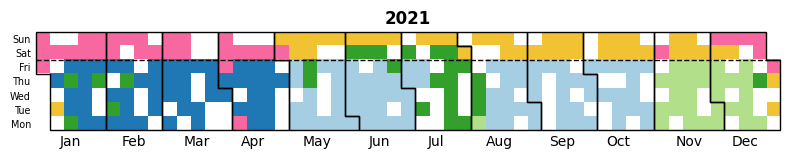

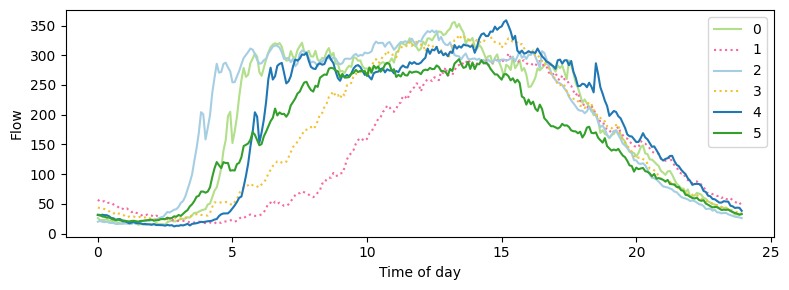

In [55]:
#selected model
clusters = KMeans(n_clusters=6, random_state=42).fit(X_train)

if clusters is not None:
  cluster_labels = clusters.labels_
#Plot again
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_train_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_train_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# This function 'make_calendar_visualization_figure' is used to generate a visualization based on the provided data and parameters.
# 'days_not_nans' are the days, 'cluster_labels' are the cluster labels, 'n_clusters_t' is the number of clusters,
# '[2021]' represents the year, 'days_colors' represent the assigned colors for each day, 'color_to_cluster' maps colors to clusters,
# and 'save_figure' is an optional parameter to save the generated figure (can be None if not saving).

# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(X_train[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

External evaluation

In [49]:
# Read the evaluation dataset from a CSV file
data_eval_df = pd.read_csv("evaluation_dataset_exercise_5_clustering_highway_traffic.csv", sep=";")

# Sort the evaluation DataFrame by columns "Date" and "Interval_5"
data_eval_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted evaluation DataFrame
days_eval = np.unique(data_eval_df[['Date']].values.ravel())
# Calculate the total number of unique days in the evaluation dataset
ndays_eval = len(days_eval)

# Group the evaluation DataFrame by the "Date" column
day_eval_subsets_df = data_eval_df.groupby(["Date"])

# Initialize a matrix 'vectorized_day_dataset_eval' filled with NaN values
vectorized_day_dataset_eval = np.zeros((ndays_eval, nintvals))
vectorized_day_dataset_eval.fill(np.nan)
# This section initializes a 2D array to store the evaluation dataset and fills it with NaN values.

# Loop through each unique day in the evaluation dataset
for i in range(0, ndays_eval):
    # Get the DataFrame corresponding to the current day
    df_t = day_eval_subsets_df.get_group(days_eval[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame (this line is redundant)
        df_t = day_eval_subsets_df.get_group(days_eval[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset_eval'
        vectorized_day_dataset_eval[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset_eval'
print(vectorized_day_dataset_eval)

/tmp/ipython-input-3223714943.py:23: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_eval_subsets_df.get_group(days_eval[i])
/tmp/ipython-input-3223714943.py:28: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_eval_subsets_df.get_group(days_eval[i])


[[35. 29. 32. ... 62. 66. 71.]
 [44. 44. 51. ... 30. 31. 23.]
 [21. 22. 17. ... 20. 22. 22.]
 ...
 [17. 17. 20. ... 35. 25. 27.]
 [37. 25. 30. ... 37. 36. 49.]
 [42. 28. 32. ... 45. 49. 38.]]


In [50]:
# Calculate the total number of NaN values in the evaluation dataset
print('Number of NaNs:', np.sum(np.isnan(vectorized_day_dataset_eval)))

# Calculate the rate of NaN values in the evaluation dataset
print('Rate of NaNs:', np.sum(np.isnan(vectorized_day_dataset_eval)) / (ndays_eval * nintvals))

# Calculate the number of days with missing values
nans_per_day_eval = np.sum(np.isnan(vectorized_day_dataset_eval), 1)
print('Number of days with missing values:', np.size(np.where(nans_per_day_eval > 0)))

# Filter out days with no missing values and create a new dataset
vectorized_day_dataset_no_nans_eval = vectorized_day_dataset_eval[np.where(nans_per_day_eval == 0)[0], :]
days_not_nans_eval = days_eval[np.where(nans_per_day_eval == 0)[0]]

# Calculate the final number of days in the evaluation dataset after removing missing values
print('Final number of days in evaluation dataset:', len(days_not_nans_eval))

# Print the list of days in the evaluation dataset with no missing values
print('List of days without missing values:', days_not_nans_eval)

# Calculate the total number of days in the filtered evaluation dataset
ndays_eval_not_nans = len(days_not_nans_eval)

Number of NaNs: 96
Rate of NaNs: 0.004166666666666667
Number of days with missing values: 11
Final number of days in evaluation dataset: 69
List of days without missing values: [20220108 20220109 20220131 20220204 20220209 20220210 20220211 20220223
 20220226 20220227 20220302 20220304 20220305 20220306 20220310 20220314
 20220315 20220321 20220323 20220326 20220403 20220406 20220416 20220418
 20220421 20220422 20220425 20220427 20220428 20220503 20220505 20220514
 20220519 20220521 20220522 20220526 20220530 20220601 20220603 20220609
 20220616 20220619 20220623 20220628 20220704 20220711 20220712 20220904
 20220910 20220911 20220920 20220921 20220925 20220927 20220929 20220930
 20221005 20221022 20221024 20221114 20221116 20221121 20221122 20221213
 20221216 20221218 20221220 20221223 20221230]


In [56]:

# Initialize a list to store centroid data
centroids = []

# Calculate centroids for each cluster
for i in np.unique(cluster_labels):
    centroid = np.nanmean(X_train[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
    centroids.append(centroid)

# Define the number of past intervals to consider for classification
n_past_intervals_for_classification = 5

# Initialize variables to calculate accuracy metrics
total_mae = 0
total_mape = 0
prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
for i in range(0, ndays_eval_not_nans):
    # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
    for j in range(n_past_intervals_for_classification, nintvals - 1):
        # Find the closest centroid for the current data point
        centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

        # Predict the value for the next interval
        predicted_value = centroids[centroid_index][0, j + 1]

        # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
        mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
        mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

        # Accumulate MAE, MAPE, and count of predictions
        total_mae += mae_t
        total_mape += mape_t
        prediction_counts += 1

# Calculate and print the prediction accuracy metrics
print('Prediction accuracy MAE:', total_mae / prediction_counts)
print('Prediction accuracy MAPE:', total_mape / prediction_counts)


Prediction accuracy MAE: 21.338445326621247
Prediction accuracy MAPE: 0.2783431984018561
